# Module 4 Project - Sample Solution

## Import Necessary Packages

Needed for this lab:

* pandas, numpy, matplotlib for the normal stuff
* TimeGrouper from pandas, for dealing with datetimes more easily
* ARIMA model from statsmodels
* Helper functions from statsmodels, for plotting Time Series (optional)
* TQDM, for visualizing progress bars for long runtimes (optional)

In [3]:
import pandas as pd
from tqdm import tqdm
from pandas import TimeGrouper
import numpy as np
from matplotlib import pyplot
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import operator
%matplotlib inline

# Step 1: Load and Inspect Data

Load data directly from `zillow_data.csv`. Cast `'RegionName'` column to `str` during loading process. 


## A Note on Null Values

This dataset contains missing values. There are three possible cases for null values in this dataset:

1. A sequence of missing values at the start of the time series. This is seen with newer zipcodes, which will have missing values for any date before the creation of that zipcode. 
2. A sequence of missing values at the end of the time series. This is seen with zipcodes that were dissolved after a rezoning. 
3. Spontaneous missing values, with no pattern. These are just run-of-the-mill missing values.

Only null values of type '3' can be imputed safely. Please note that this is not done in this example notebook--instead, all zipcodes with any missing values are simply dropped. 

In [4]:
# Import and inspect the data
raw_data_df = pd.read_csv('zillow_data.csv', dtype={'RegionName': 'str'})
raw_data_df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


# Step 2: Drop Unneeded Columns

We don't need `'SizeRank'` or `'RegionID'`, so let's drop them. 

In [5]:
df1 = raw_data_df.drop(['SizeRank', 'RegionID'], axis=1, inplace=False)
df1.head()

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,60657,Chicago,IL,Chicago,Cook,334200.0,335400.0,336500.0,337600.0,338500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,75070,McKinney,TX,Dallas-Fort Worth,Collin,235700.0,236900.0,236700.0,235400.0,233300.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,77494,Katy,TX,Houston,Harris,210400.0,212200.0,212200.0,210700.0,208300.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,60614,Chicago,IL,Chicago,Cook,498100.0,500900.0,503100.0,504600.0,505500.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,79936,El Paso,TX,El Paso,El Paso,77300.0,77300.0,77300.0,77300.0,77400.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


### Example: Filtering Zipcodes for Arkansas

Zipcodes were retrieved by searching city zipcodes on Google. Store each as a string inside separate lists. 

In [6]:
## Zipcodes for AK metro areas
hot_springs = ['71901', '71902', '71903', '71913', '71914']
little_rock = ['72002', '72203', '72207', '72212', '72219', '72225', '72260', '72103', 
               '72204', '72209', '72214', '72221', '72227', '72295', '72201', '72205', 
               '72210', '72215', '72222', '72231', '72202', '72206', '72211', '72217', 
               '72223', '72255']
fayetteville = ['72701', '72702', '72703', '72704', '72730', '72764']
searcy = ['72082', '72143', '72145', '72149']

ar_city_zipcodes = hot_springs + little_rock + fayetteville + searcy

ar_city_zipcodes

['71901',
 '71902',
 '71903',
 '71913',
 '71914',
 '72002',
 '72203',
 '72207',
 '72212',
 '72219',
 '72225',
 '72260',
 '72103',
 '72204',
 '72209',
 '72214',
 '72221',
 '72227',
 '72295',
 '72201',
 '72205',
 '72210',
 '72215',
 '72222',
 '72231',
 '72202',
 '72206',
 '72211',
 '72217',
 '72223',
 '72255',
 '72701',
 '72702',
 '72703',
 '72704',
 '72730',
 '72764',
 '72082',
 '72143',
 '72145',
 '72149']

In [7]:
ar_cities_df = df1[df1['RegionName'].isin(ar_city_zipcodes)]
ar_cities_df

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
297,71913,Hot Springs,AR,Hot Springs,Garland,82100.0,81900.0,81600.0,81300.0,81000.0,...,145500,145700,146500,147500,148100,147300,146400,146200,146400,146300
799,72701,Fayetteville,AR,Fayetteville,Washington,83100.0,83500.0,83700.0,83800.0,83700.0,...,194200,195400,196600,198500,201100,203800,206100,208700,211700,214000
868,72764,Springdale,AR,Fayetteville,Washington,NaN,NaN,NaN,NaN,NaN,...,143200,143700,144300,144900,145800,146600,147100,148300,150300,152000
1596,72703,Fayetteville,AR,Fayetteville,Washington,104900.0,105300.0,105600.0,105800.0,106000.0,...,219600,220300,220900,222400,223900,225100,225500,226300,227600,228500
2240,72143,Searcy,AR,Searcy,White,73800.0,74100.0,74300.0,74600.0,74800.0,...,120300,120500,121000,121300,121600,122400,123600,125000,126100,126500
2392,72204,Little Rock,AR,Little Rock,Pulaski,39000.0,39300.0,39500.0,39800.0,40000.0,...,65800,65400,65500,66500,67300,67600,67900,67700,66600,65800
2616,71901,Hot Springs,AR,Hot Springs,Garland,67900.0,67800.0,67700.0,67600.0,67400.0,...,122000,122800,123500,124400,125500,126000,126600,126900,126900,126500
3230,72205,Little Rock,AR,Little Rock,Pulaski,72200.0,72400.0,72700.0,73000.0,73300.0,...,153200,153000,152100,151400,150700,151000,152100,152900,153100,153400
3413,72704,Fayetteville,AR,Fayetteville,Washington,92800.0,92600.0,92000.0,91200.0,90400.0,...,178800,180400,182100,183400,184600,185500,186300,187500,189100,189800
3606,72211,Little Rock,AR,Little Rock,Pulaski,110000.0,110300.0,110400.0,110400.0,110300.0,...,177400,178100,179000,179100,179100,178600,177500,177000,176900,176900


### Example: Filtering by City Name

Can also get zipcodes for a given city by filtering by the name of the city. 

In [8]:
# Check that zipcodes starting with 0 are now formatted correctly
df1[df1['City'] == 'Agawam']

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
5850,01001,Agawam,MA,Springfield,Hampden,113100.0,112800.0,112600.0,112300.0,112100.0,...,213900,215700,218200,220100,221100,221700,221700,221700,222700,223600
7801,01030,Agawam,MA,Springfield,Hampden,121700.0,121500.0,121200.0,121000.0,120800.0,...,238600,238700,239500,239500,238500,237400,236700,236600,237900,239300


# Step 4: Creating Time Series Plots

### Step 4.1: Filter by Zipcodes

In this example, we slice the relevant zipcodes for each of our example cities into separate DataFrames. This will make visualizing them easier. 

In [9]:
# Create data sets containing zip codes for AR metro area
searcy_df = df1[df1['RegionName'].isin(searcy)]
littlerock_df = df1[df1['RegionName'].isin(little_rock)]
fayetteville_df = df1[df1['RegionName'].isin(fayetteville)]
hotsprings_df = df1[df1['RegionName'].isin(hot_springs)]

display(searcy_df)
display(littlerock_df)
display(fayetteville_df)
display(hotsprings_df)

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2240,72143,Searcy,AR,Searcy,White,73800.0,74100.0,74300.0,74600.0,74800.0,...,120300,120500,121000,121300,121600,122400,123600,125000,126100,126500


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2392,72204,Little Rock,AR,Little Rock,Pulaski,39000.0,39300.0,39500.0,39800.0,40000.0,...,65800,65400,65500,66500,67300,67600,67900,67700,66600,65800
3230,72205,Little Rock,AR,Little Rock,Pulaski,72200.0,72400.0,72700.0,73000.0,73300.0,...,153200,153000,152100,151400,150700,151000,152100,152900,153100,153400
3606,72211,Little Rock,AR,Little Rock,Pulaski,110000.0,110300.0,110400.0,110400.0,110300.0,...,177400,178100,179000,179100,179100,178600,177500,177000,176900,176900
3869,72223,Little Rock,AR,Little Rock,Pulaski,195200.0,194600.0,194000.0,193300.0,192600.0,...,321200,321600,322100,322400,322600,322700,323000,323700,324600,324900
6319,72210,Little Rock,AR,Little Rock,Pulaski,97300.0,97100.0,96900.0,96500.0,96100.0,...,167600,168200,169000,170300,172700,176100,179600,182000,181700,180200
6446,72002,Shannon Hills,AR,Little Rock,Saline,77300.0,77300.0,77200.0,77100.0,76900.0,...,151100,152300,153300,154200,155300,156900,158200,157900,156800,156700
6944,72103,Little Rock,AR,Little Rock,Pulaski,61500.0,61700.0,61900.0,62100.0,62300.0,...,117500,118300,119300,120800,122100,123600,125700,126500,126100,125900
7162,72227,Little Rock,AR,Little Rock,Pulaski,115700.0,115600.0,115500.0,115400.0,115400.0,...,191100,190900,190600,191500,192700,193500,194000,194300,193300,191900
7309,72207,Little Rock,AR,Little Rock,Pulaski,113700.0,114000.0,114300.0,114700.0,115100.0,...,262600,262900,262800,261200,260200,261300,262700,263400,265100,267100
7552,72212,Little Rock,AR,Little Rock,Pulaski,177200.0,177100.0,176900.0,176700.0,176500.0,...,268000,269300,269200,268500,269000,269600,270000,270400,270600,270600


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
799,72701,Fayetteville,AR,Fayetteville,Washington,83100.0,83500.0,83700.0,83800.0,83700.0,...,194200,195400,196600,198500,201100,203800,206100,208700,211700,214000
868,72764,Springdale,AR,Fayetteville,Washington,NaN,NaN,NaN,NaN,NaN,...,143200,143700,144300,144900,145800,146600,147100,148300,150300,152000
1596,72703,Fayetteville,AR,Fayetteville,Washington,104900.0,105300.0,105600.0,105800.0,106000.0,...,219600,220300,220900,222400,223900,225100,225500,226300,227600,228500
3413,72704,Fayetteville,AR,Fayetteville,Washington,92800.0,92600.0,92000.0,91200.0,90400.0,...,178800,180400,182100,183400,184600,185500,186300,187500,189100,189800
8643,72730,Farmington,AR,Fayetteville,Washington,84000.0,83900.0,83600.0,83200.0,82700.0,...,163600,164800,165800,165900,166000,166800,167900,170400,174000,176100


,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
297,71913,Hot Springs,AR,Hot Springs,Garland,82100.0,81900.0,81600.0,81300.0,81000.0,...,145500,145700,146500,147500,148100,147300,146400,146200,146400,146300
2616,71901,Hot Springs,AR,Hot Springs,Garland,67900.0,67800.0,67700.0,67600.0,67400.0,...,122000,122800,123500,124400,125500,126000,126600,126900,126900,126500


## Step 2 again: more cleaning

For our Time Series Plots, we only need the `RegionName` and the actual median housing values for each.  This means that we can drop everything else. 

In [10]:
cols_to_drop = ['City', 'State', 'Metro', 'CountyName']
searcy_clean_df = searcy_df.drop(cols_to_drop, axis=1, inplace=False)
fayetteville_clean_df = fayetteville_df.drop(cols_to_drop, axis=1, inplace=False)
hotsprings_clean_df = hotsprings_df.drop(cols_to_drop, axis=1, inplace=False)
littlerock_clean_df = littlerock_df.drop(cols_to_drop, axis=1, inplace=False)

## Step 2 again: Get Datetimes

We will use the datetimes as our indices for these plots. Currently, the column names for each remaining column that is not the zipcode in question is contains the datetimes. These datetimes are stored as strings, in the format `'%Y-%m'`. 

In the cell below, we create a series called `datetimes` using pandas and the column values for one of the cities (we exclude the first column value, since this contains `'RegionName'`).

In [11]:
datetimes = pd.to_datetime(searcy_clean_df.columns.values[1:], format='%Y-%m')

### Step 4.2: Set Params for Matplotlib Visualizations

This step is optional, but will make our plots easier to read.

In [12]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

### Step 4.3: Create a Function for Visualizing Time Series Data

This one is a bit complicated, so the code is commented and broken down line by line. 

**_NOTE_**: For the example below, we've only visualized the data for 1997 through 2013. This was done on purpose, to show how to visualize select ranges of data. The index values were obtained by manually looking at the date ranges and determining that `[10:215]` includes everything between 1997 and 2013. 

/Users/paulyun/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/paulyun/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/paulyun/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


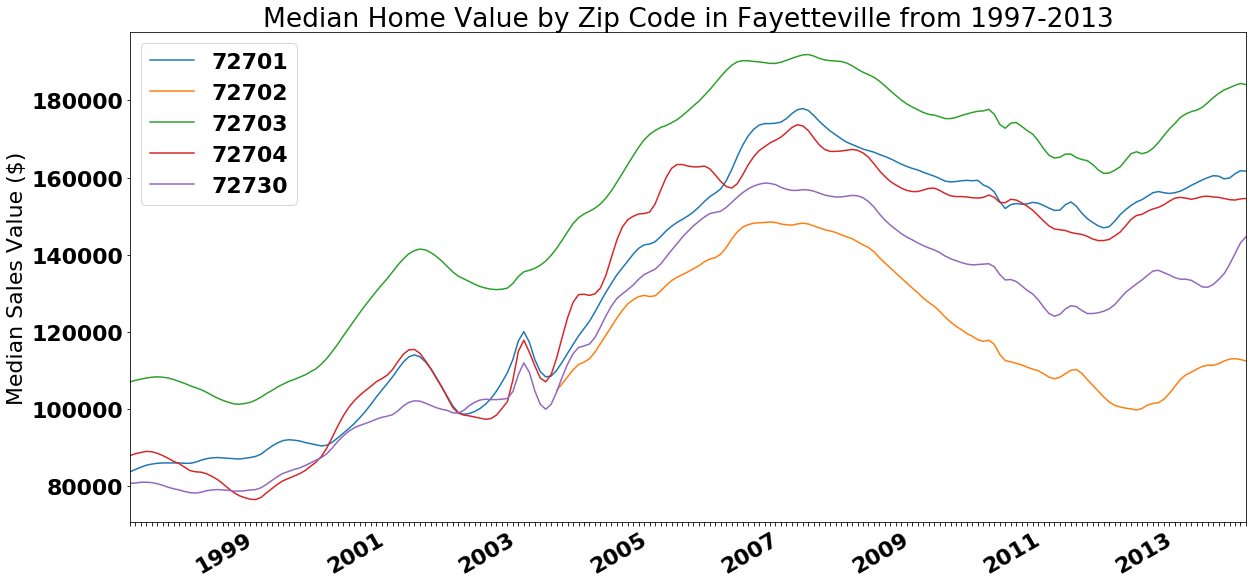

In [13]:

def time_series(df, name=None, legend=None):
    
    # Instantiate a figure object. 
    plt.figure()
    if not legend:
        legend = list(df['RegionName'])
    # Enumerate through each row in the dataframe passed in. Each row is a different zipcode.
    for ind, row in df.iterrows():
        
        # Get the median housing value data for the date ranges we want and store in a Series object
        data = pd.Series(row.iloc[10:215])
        # Set the appropriate datetimes for data as the index for our data series
        data.index = datetimes[10:215]
        # Plot data for current zipcode on figure we instantiated on line 4. Set xticks to corresponding datetimes
        # Also make the figure large, so that we can read it more easily
        ax = data.plot(figsize=(20, 10), xticks=datetimes[10:215])
        # add a label
        plt.ylabel("Median Sales Value ($)")
        # let matplootlib autoformat the datetimes for the xticks
        plt.gcf().autofmt_xdate()
        
        # If name of city was provided, use it to set title of plot
        if name:
            plt.title("Median Home Value by Zip Code in {} from 1997-2013".format(name))
        else:
            plt.title("Avg Median Home Value in AR Metro Area, 1997-2013")
        
    plt.legend(legend)
            
    plt.show()
        

time_series(fayetteville_clean_df, name='Fayetteville', legend=fayetteville)
# time_series(searcy_clean_df, name='Searcy')
# time_series(hotsprings_clean_df, hot_springs, 'Hot Springs')
# time_series(littlerock_clean_df, little_rock, 'Little Rock')

### Step 4.4: Visualizing the Average Median Home Sale Price for a Collection of Zipcodes

To visualize the average median home sales value for an area, we can use the function we created above, but we need to do a bit of processing first to get it into the shape needed. 

1. First, we concatenate all of the dataframes containing the zipcodes we want to average.
2. Next, we create a new DataFrame containing a single column of data called `'Avg_Median_Value'` for the date range we want (in this example, still focusing only on values between 1997-2013). 
3. Next, drop the `'RegionName'` column.
4. Finally, inspect the data to see what our newly computed `'Avg_Median_Value'` data looks like. 

In [14]:
arkansas_metro_df = pd.concat([searcy_clean_df, littlerock_clean_df, fayetteville_clean_df, hotsprings_clean_df])
avg_metro_value_df = pd.DataFrame(arkansas_metro_df[10:215].mean(), columns=['Avg_Median_Value'])
avg_metro_value_df.drop('RegionName', axis=0, inplace=True)
avg_metro_value_df.head()

,Avg_Median_Value
1996-04,98857.142857
1996-05,98871.428571
1996-06,98728.571429
1996-07,98514.285714
1996-08,98242.857143


The data looks fine, but it need to be transposed in order to work with the function we've written. 

Note that we can chance the value of our legend to whatever string we want by wrapping it in an array and passing it in to the `legend` parameter.

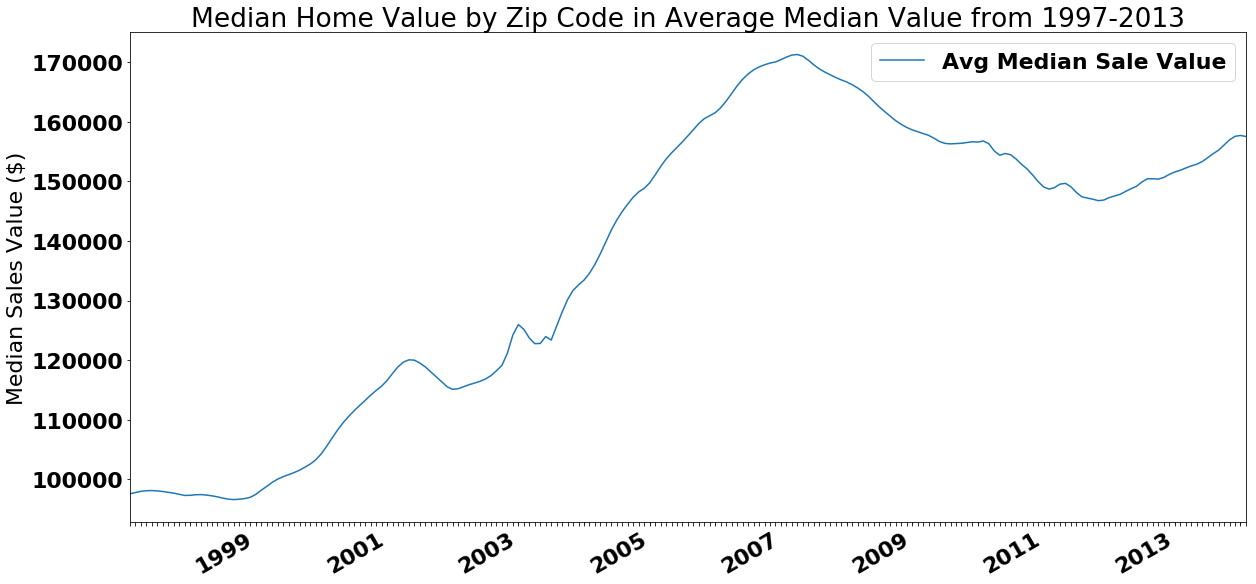

In [15]:
time_series(avg_metro_value_df.transpose(), name="Average Median Value", legend=['Avg Median Sale Value'])

(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

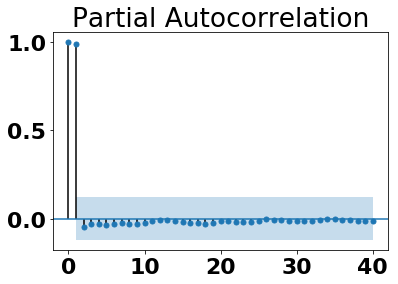

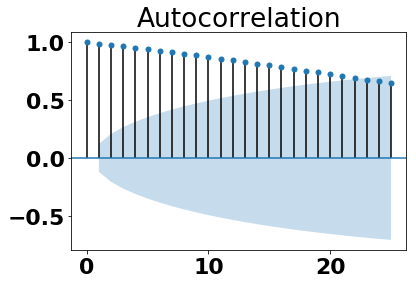

In [27]:
import statsmodels.api as sm

sm.graphics.tsa.plot_pacf(avg_metro_value_df.values, lags=40), sm.graphics.tsa.plot_acf(avg_metro_value_df.values, lags=25)

# Step 5: ARIMA Modeling 

The next section demonstrates how to do ARIMA modeling on this data set. 

## 'Melting' the Data

In order to train the model, we need to first **_melt_** the data into the appropriate shape. ARIMA models expect the data in columnar format ("long"), and in our current format, the values are stored in rows ("wide"). 

The cell below shows some sample code for melting a dataframe, and displays the same dataframe in both wide (unmelted) and long (melted) formats. 

In [17]:
melted = pd.melt(searcy_df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
melted = melted.dropna(subset=['value'])

display(searcy_df.head())
melted.head(10)

,RegionName,City,State,Metro,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
2240,72143,Searcy,AR,Searcy,White,73800.0,74100.0,74300.0,74600.0,74800.0,...,120300,120500,121000,121300,121600,122400,123600,125000,126100,126500


,RegionName,City,State,Metro,CountyName,time,value
0,72143,Searcy,AR,Searcy,White,1996-04-01,73800.0
1,72143,Searcy,AR,Searcy,White,1996-05-01,74100.0
2,72143,Searcy,AR,Searcy,White,1996-06-01,74300.0
3,72143,Searcy,AR,Searcy,White,1996-07-01,74600.0
4,72143,Searcy,AR,Searcy,White,1996-08-01,74800.0
5,72143,Searcy,AR,Searcy,White,1996-09-01,75100.0
6,72143,Searcy,AR,Searcy,White,1996-10-01,75400.0
7,72143,Searcy,AR,Searcy,White,1996-11-01,75700.0
8,72143,Searcy,AR,Searcy,White,1996-12-01,76000.0
9,72143,Searcy,AR,Searcy,White,1997-01-01,76400.0


### Step 5.1: Create a Function for Melting Data

Since this is an operation we'll need to for any group of data we want to format for ARIMA modeling, we should create a function in order to save ourselves some time. 

In [18]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 6: Creating a Function to Evaluate Results

Before we actually fit the model, we'll create a function that creates predictions for datetimes with known values based on the previous data, and then compare the lagged predictions with ground truth values from our time series data. 

In [19]:
def get_results(df, preds, name):
    if 'pandas.core.frame.DataFrame' in str(type(df)):
        current_price = df.iloc[-1].value
    else:
        current_price = df[-1]
    year_later = preds[11]
    year_3_val = preds[35]
    year_5_val = preds[-1]

    print("Current Avg Median Home Value in {}: ${:.2f}".format(name, current_price))
    print("Predicted Avg Median Home Value for {} in April 2019: ${:.2f}".format(name, year_later))
    expected_appreciation_value_1 = year_later - current_price
    expected_appreciation_percent_1 = expected_appreciation_value_1 / current_price
    expected_appreciation_value_3 = year_3_val - current_price
    expected_appreciation_percent_3 = expected_appreciation_value_3 / current_price
    expected_appreciation_value_5 = year_5_val - current_price
    expected_appreciation_percent_5 = expected_appreciation_value_5 / current_price

    print("Expected property value appreciation for 1 year in {} :  ${:.2f}".format(name, expected_appreciation_value_1))
    print("Expected Return on Investment after 1 year:  {:.4f}%".format(expected_appreciation_percent_1 * 100))
    print("Expected property value appreciation for 3 years in {} :  ${:.2f}".format(name, expected_appreciation_value_3))
    print("Expected Return on Investment after 3 years:  {:.4f}%".format(expected_appreciation_percent_3 * 100))
    print("Expected property value appreciation for 5 years in {} :  ${:.2f}".format(name, expected_appreciation_value_5))
    print("Expected Return on Investment after 5 years:  {:.4f}%".format(expected_appreciation_percent_5 * 100))

# Step 7: Fitting Our ARIMA Model

Finally, we create a `fit_model()` function that takes in our (melted!) dataframe, the zipcode (for display purposes), and an optional parameter for visualizing the results of our model's fit. 

The function below has been commented to explain what is happening at each step. 

In [28]:
def fit_model(df, zipcode, show_graph=True):
    # Get only the values from the dataframe
    vals = df.values
    # Split the data into training and testing sets by holding out dates past a certain point. Below, we use index 261 for 
    # this split
    train = vals[:261]
    test = vals[261:]
    
    # Use a list comprehension to create a "history" list using our training data values
    history = [i for i in train]
   
    # initialize an empty list for predictions
    preds = []
    
    # loop through a list the length of our training set
    for i in range(len(test)):
        
        # create an ARIMA model and pass in our history list. Also set `order=(0,1,1)` (order refers to AR and MA params--
        # see statsmodels documentation for ARIMA for more details)
        model = ARIMA(history, order=(1,1,21))
        
        # Fit the model we just created
        fitted_model = model.fit(disp=0)
        # Get the forecast of the next value from our fitted model, and grab the first value to use as our 'y-hat' prediction
        output = fitted_model.forecast()
        y_hat = output[0]
        
        # append y_hat to our list of predictions
        preds.append(y_hat)
        obs = test[i]
        
        # Get the actual ground truth value for this datetime and append it to the history array
        history.append(obs)
    
    
    # get the forecast for the next three years (1 month==1 timestep in our data)
    future_preds = fitted_model.forecast(steps=36)[0]

    # Visualize the ARIMA model's predictions vs the actual ground truth values for our test set
    if show_graph == True:
        print('Predicted: {} \t Expected: {}'.format(y_hat, obs))
        # Also calculate the MSE
        mse = mean_squared_error(test, preds)
        print("MSE for Test Set: {}".format(mse))
        plt.plot(test)
        plt.plot(preds, color='r')
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted vs Expected Median Home Sale Values'.format(zipcode))
        plt.legend(['Actual', 'Predicted'])
        plt.show()

        
        plt.figure()
        plt.plot(future_preds)
        plt.ylabel('Median Home Value ($)')
        plt.title('Predicted Home Value, {}, Next 36 Months'.format(zipcode))
        plt.show()
        get_results(df, future_preds, zipcode)
        
    return future_preds

In [29]:
aggregate_df = melt_data(df1)
aggregate_df.head()

,value
time,
1996-04-01,118299.123063
1996-05-01,118419.044139
1996-06-01,118537.423268
1996-07-01,118653.069278
1996-08-01,118780.254312


In [ ]:
_ = fit_model(aggregate_df, "US")

# Optional: Compare Forecasts for Every Zipcode in US

The following cells demonstrate how to use all the code written so far to create and compare 5-year forecasts for every zipcode in the dataset. Note that this is well outside the scope of the project!

**_NOTE: Running the cells below takes >1 hour on a fast computer!_**

In [23]:
def model_data_by_zip(df, num_top_zips=3):
    
    df.dropna(axis=0, inplace=True)
    zip_roi_12_month = {}
    zip_roi_36_month = {}
    zip_roi_60_month = {}
    
    # Get 12-month RoI for each zipcode
    with tqdm(total=len(list(df.iterrows()))) as pbar:
        for ind, row in df.iterrows():
            pbar.update(1)
            series = pd.Series(row)
            name = series[0]
            data = series[5:]

            preds_for_zip = fit_model(data, name, show_graph=False)
            last_val = row[-1]
            predicted_val_12 = preds_for_zip[11]
            predicted_val_36 = preds_for_zip[35]
            predicted_val_60 = preds_for_zip[-1]
            roi_12 = (predicted_val_12 - last_val) / last_val
            roi_36 = (predicted_val_36 - last_val) / last_val
            roi_60 = (predicted_val_60 - last_val) / last_val
            zip_roi_12_month[name] = roi_12
            zip_roi_36_month[name] = roi_36
            zip_roi_60_month[name] = roi_60
    
    # Sort dict by values and return amount specified by optional parameter, default 3
    sorted_by_roi_12 = sorted(zip_roi_12_month.items(), key=operator.itemgetter(1), reverse=True)
    sorted_by_roi_36 = sorted(zip_roi_36_month.items(), key=operator.itemgetter(1), reverse=True)
    sorted_by_roi_60 = sorted(zip_roi_60_month.items(), key=operator.itemgetter(1), reverse=True)
    
    return (sorted_by_roi_12[:num_top_zips], sorted_by_roi_36[:num_top_zips], sorted_by_roi_60[:num_top_zips])

In [24]:
def format_results(results):
    results_12 = results[0]
    results_36 = results[1]
    results_60 = results[2]
    
    print("Top Zip Codes for Predicted RoI--1 Year")
    
    for zipcode, roi in results_12:
        print("Zipcode: {} \t Predicted 12-month RoI: {:.6f}%".format(zipcode, roi * 100))
    
    print("")
    print('-' * 60)
    print("")
    
    print("Top Zip Codes for Predicted RoI--3 Years")
    
    for zipcode, roi in results_36:
        print("Zipcode: {} \t Predicted 36-month RoI: {:.6f}%".format(zipcode, roi * 100))
        
    print("")
    print('-' * 60)
    print("")
    
    print("Top Zip Codes for Predicted RoI--5 Years")
    
    for zipcode, roi in results_60:
        print("Zipcode: {} \t Predicted 60-month RoI: {:.6f}%".format(zipcode, roi * 100))
        

In [25]:
# insert zipcode here
format_results()

TypeError: format_results() missing 1 required positional argument: 'results'